<a href="https://colab.research.google.com/github/GiriprasadKrishnamurthy/daksh-recruitment/blob/main/Main_Program_For_Training_and_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#datapreprovessing

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def generate_iterator(path, augmentation = True, color_mode = 'rgb',
                      batch_size = 32, shuffle = True, target_size = (128, 128),
                      seed = None, interpolation = 'bilinear', rescale = 1/255.0):
    """
    This function will generate the iterator, that will be used for training, validation,
    and testing.
    
    Arguments:
    
    path --> This is the path of the original directory. It is assumed that this string contains
             the complete path; like "D:/Datasets/DiabeticRetinopathy/UWF_Dataset/UWF/train".
    augmentation --> It is a boolean. If True, only two augmentation will be applied otherwise, no.
    olor_mode --> It is either 'rgb' or 'gray'. The default value is 'rgb'
    batch_size = An integer, the default value is 32.
    shuffle --> A boolean, and the default value is True. For validation and testing data it should be False.
    target_size --> A tuple mentioning the size of the input image (rows, cols, channels). The default
                    value is (128, 128, 3).
                    
    seed --> An integer. The default value is None
    interpolation --> A string, the default value is  'nearest'
    rescale --> rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value
                provided (after applying all other transformations)
    
    Return:
    
    iterator --> An iterator
    """
    
    if augmentation:
        Generator = ImageDataGenerator(rescale = rescale,
                                       horizontal_flip = True, 
                                       vertical_flip = True,
                                       rotation_range = 5,
                                      zoom_range = 0.02) 
#                                        shear_range = 0.02,
#                                        zoom_range = 0.02)
#                                        samplewise_center=True, 
#                                        samplewise_std_normalization= True)
    else:
        Generator = ImageDataGenerator(rescale = rescale)
        
    Iterator = Generator.flow_from_directory(directory = path, target_size=target_size,
                                             color_mode='rgb', batch_size=batch_size,
                                             shuffle=shuffle, seed=None, interpolation='bilinear')
    return Iterator


def display_images(iterator):
    """
    This function will display images.
    
    Argument:
    
    iterator --> The input should be an iterator with shape (batch_size, rows, cols, channels)
    
    Return: This function does not return anything; instead, it displays the images of the given 
            iterator.
    """
    classes = list(iterator.class_indices)
    images, labels = iterator.next()
    plt.figure(figsize = (8,8))
    if np.max(images[0,...]) <= 1:
        for i in range(0, 25):
            plt.subplot(5,5,i+1)
            plt.imshow(images[i,...])
            plt.title(classes[np.argmax(labels[i])])
            plt.axis('off')
    else:
        for i in range(0, 25):
            plt.subplot(5,5,i+1)
            plt.imshow(images[i,...].astype('uint8'))
            plt.title(classes[np.argmax(labels[i])])
            plt.axis('off')          
    plt.tight_layout()
    

In [ ]:
#metric_and_plot
# Imports
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import confusion_matrix


mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall', "Specificity", "Sensitivity"]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,3,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', linestyle = 'dashdot', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],color='red', linestyle="solid", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        
        plt.legend()
        
        
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels.argmax(axis=1), predictions.argmax(axis=1))
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('0 detected as 0 (True Negatives): ', cm[0][0])
    print('1 detected as 1 (True Negatives): ', cm[1][1])
    print('2 detected as 2 (True Negatives): ', cm[2][2])
    print('3 detected as 3 (True Negatives): ', cm[3][3])
    print('4 detected as 4 (True Negatives): ', cm[4][4])
    
    
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    
    
#####################################################################################################
def plot_roc(y_test, y_score, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # Plot all ROC curves
    plt.figure()
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lime",
                    "blue", "deeppink", "black", "tan", "green", "red"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

    plt.plot([-1, 1], [-1, 1], "k--", lw=4)
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
    plt.title("Receiver operating characteristic to multiclass")
    plt.legend(loc="best")
    plt.show()

In [ ]:
#model creation

# Imports
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, LayerNormalization, MaxPooling2D
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Add, AveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical

##### CODE FOR MODEL #####################

def CNNBlock(inputs, filters = 16, kernel_size = 3, strides = 1, 
             Normalization = 'layer_normalization'):
    """
    This function will create a CNN block (Conv2D --> BN --> Activation)
    
    Arguments:
    inputs --> This is the input of shape (batch_size, rows, cols, channels)
    filters --> This is the input of number of filters used in the convolution layer.
    kernel_size --> the size of the filter. The default value is 3x3
    strides --. A scalar integer. The default value is 1.
    Normalization --> This input is a string, which will decide the type of normalization,
                      you want to use in your model. The default value is 'layer_normalization'.
                      The other two options are 'batch_normalization' and 'batch_renormalization'.
                      
    Return:
    outputs --> This is the output of the block of shape (batch_size, rows, cols, filters)
    """
    x = Conv2D(filters, kernel_size=kernel_size, padding = 'same',
              strides = strides)(inputs)
    if Normalization == 'layer_normalization':
        x = LayerNormalization()(x)
    elif Normalization == 'batch_normalizatin':
        x = BatchNormalization()(x)
    elif Normalization == 'batch_renormalizatin':
        x = BatchNormalization(renorm = True)(x)
    else:
        print("Unknown Type of Input for Normalizatin")
    
    x = Activation(activation='relu')(x)
    return x


def Residual_Block(inputs, blocks = 3, filter_bank = [16, 16, 32], kernel_size = 3,
                   strides = 1, Normalization = 'layer_normalization'):
    """
    This function will be used to create the residual block. 
    
    Arguments:
    
    inputs --> This is the input of shape (batch_size, rows, cols, channels)
    blocks -> This will define the number of blocks you want your model to have. The default value is 3.
    filter_bank --> This input contains the values of fitlers to be used in each residual block.
    kernel_size --> the size of the filter. The default value is 3x3
    strides --. A scalar integer. The default value is 1.
    Normalization --> This input is a string, which will decide the type of normalization,
                      you want to use in your model. The default value is 'layer_normalization'.
                      The other two options are 'batch_normalization' and 'batch_renormalization'.
                      
    Return:
    outputs --> This is the output of the block of shape (batch_size, rows, cols, filters)
    """
    x = inputs
    for block in range(blocks):
        for filters in filter_bank:
            x = CNNBlock(inputs=x, filters=filters)
        x = Add()([x, Conv2D(filters = filter_bank[-1], 
                             kernel_size = kernel_size, padding = 'same')(inputs)])
        inputs = x
    return x

def Transition_Block(inputs, filter_bank = [16, 16, 32], kernel_size = 3,
                     strides = 2, Normalization = 'layer_normalization'):
    """
    This function will be used to create the transition block. 
    
    Arguments:
    
    inputs --> This is the input of shape (batch_size, rows, cols, channels)
    blocks -> This will define the number of blocks you want your model to have. The default value is 3.
    filter_bank --> This input contains the values of fitlers to be used in each residual block.
    kernel_size --> the size of the filter. The default value is 3x3
    strides --. A scalar integer. The default value is 1.
    Normalization --> This input is a string, which will decide the type of normalization,
                      you want to use in your model. The default value is 'layer_normalization'.
                      The other two options are 'batch_normalization' and 'batch_renormalization'.
                      
    Return:
    outputs --> This is the output of the block of shape (batch_size, rows, cols, filters)
    """
    x = inputs
    for filters in filter_bank[:-1]:
        x = CNNBlock(inputs=x, filters=filters, strides = 1)
    x = CNNBlock(inputs = x, filters = filter_bank[-1], strides = strides)
    x = Add()([x, Conv2D(filters = filter_bank[-1], strides = strides, 
                         kernel_size = kernel_size, padding = 'same')(inputs)])
    inputs = x
    return x

def residual_model(inputs, blocks = 4,filter_bank = [16, 16, 32], kernel_size = 3,strides = 2, 
                   Normalization = 'layer_normalization', num_classes = 5):
    """
    This function will be used to create the the residual model. 
    
    Arguments:
    
    inputs --> This is the input of shape (batch_size, rows, cols, channels)
    input_shape --> This is a tuple, defining the shape of the input data (rows, cols, channesl). The
                    default value is (128, 128, 3)
    blocks -> This will define the number of blocks you want your model to have. The default value is 3.
    filter_bank --> This input contains the values of fitlers to be used in each residual block.
    kernel_size --> the size of the filter. The default value is 3x3
    strides --. A scalar integer. The default value is 1.
    Normalization --> This input is a string, which will decide the type of normalization,
                      you want to use in your model. The default value is 'layer_normalization'.
                      The other two options are 'batch_normalization' and 'batch_renormalization'.
    num_classes --> An integer, default is 5, equal to the number of classes.
                      
    Return:
    outputs --> This is the output of the block of shape (batch_size, rows, cols, filters)
    """

    x = CNNBlock(inputs)
    filter_bank = [int(filters * 0.5) for filters in filter_bank]
    for block in range(blocks):
        filter_bank = [filters * 2 for filters in filter_bank]
        x = Residual_Block(x, filter_bank = filter_bank)
        x = Transition_Block(x, filter_bank = filter_bank)
    if Normalization == 'layer_normalization':
        x = LayerNormalization()(x)
    elif Normalization == 'batch_normalizatin':
        x = BatchNormalization()(x)
    elif Normalization == 'batch_renormalizatin':
        x = BatchNormalization(renorm = True)(x)
    else:
        print("Unknown Type of Input for Normalizatin")
    x = Activation('relu')(x)
    x = AveragePooling2D()(x)
    x = Flatten()(x)
    return x

def auxilary_model(inputs):
    """
    This will create a simple auxiliary model to help our system in detecting the features.
    """
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(inputs)
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)

    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)

    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)

    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)

    return Flatten()(x)


def final_model(input_shape = (128, 128, 3), blocks = 4,
                   filter_bank = [16, 16, 32], kernel_size = 3,strides = 2, 
                   Normalization = 'layer_normalization', num_classes = 5):
    inputs = Input(shape = input_shape)
    output1 = residual_model(inputs)
    output2 = auxilary_model(inputs)
    y = Concatenate()([output1, output2])
    outputs = Dense(units = num_classes, activation = 'softmax')(y)
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [ ]:
#MAIN.PY
# Imports
import os
import tensorflow as tf

##### CODE FOR MODEL #####################


def main(data_path, augmentation = False, callbacks = None, rescale = 0, batch_size = 32, target_size = (128, 128), 
         display_images = True, learning_rate = 0.001, input_shape = (128, 128, 3), num_classes = 5, blocks = 4, 
         metrics = None, normalization = 'layer_normalization', epochs = 50):
    """
    This function will receive the path of the data directory and will return the model and history.
    
    Arguments:
    data_path --> This is a string, which contains the path of the directory.
    callbacks --> It will contain the callbacks.
    rescale --> A scalar, the default value is 0. The other possible value is 1/255.0
    batch_size --> A scalar, the default value is 32.
    target_size --> A tuple contains rows and cols. The default value is (128, 128).
    dipslay_images --> A boolean, the default value is True. It will decide whether to display images or not.
    learning_rate --> A floating point scalar with default value 0.001.
    input_shape --> A tuple with default value (128, 128, 3)
    num_classes --> A scalar, defining the number of classes the dataset has. The default value is 5
    blocks --> An integer, with default value 4. It will decide the number of residual blocks.
    METRICS --> A list containing the metrices you want your model to examiner. The default value is None.
    Normalization --> This input is a string, which will decide the type of normalization,
                      you want to use in your model. The default value is 'layer_normalization'.
                      The other two options are 'batch_normalization' and 'batch_renormalization'.
                      
    Return:
    model --> this is the trained model
    history --> this contains the history of the training
    """
    ## Data Preparation
    train_dir = os.path.join(data_path, 'train')
    test_dir = os.path.join(data_path, 'test')
    val_dir = os.path.join(data_path, 'validation')
    
    train_iterator = data_processing.generate_iterator(path=train_dir, augmentation=augmentation, rescale=rescale)
    test_iterator = data_processing.generate_iterator(path=test_dir, augmentation=False, shuffle=False, rescale=rescale)
    validation_iterator = data_processing.generate_iterator(path=val_dir, augmentation=False, shuffle=False, rescale = rescale)
    
    if display_images:
        data_processing.display_images(train_iterator)
        

    ################ Model Creation
    model = model_creation.final_model(input_shape=input_shape, num_classes=num_classes, blocks  = blocks)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
             loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics = metrics)
    
    ############## Training
    history = model.fit(x = train_iterator, epochs = epochs, validation_data=validation_iterator,
                        callbacks=callbacks)
        
    return model, history
    

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
# Let's see our luck
print("We are running {} version of the TensorFlow,\nand we have {} GPUs Available.".format(
    tf.__version__, len(tf.config.list_physical_devices('GPU'))))

We are running 2.12.0 version of the TensorFlow,
and we have 1 GPUs Available.


In [ ]:


target_size = (128, 128)
batch_size = 32
epochs = 50
input_shape = (128, 128, 3)

METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.5, name = 'Specificity'),
    tf.keras.metrics.SensitivityAtSpecificity(specificity=0.5, name = 'Sensitivity')
]

In [ ]:


train_dir = "/content/drive/MyDrive/Training After Entropy Enhancement"
test_dir = "/content/drive/MyDrive/Testing After Entropy Enhancement"
val_dir = "/content/drive/MyDrive/Validation After Entropy Enhancement"


train_iterator = generate_iterator(path=train_dir, augmentation = True, 
                                                   rescale = 0, target_size=target_size,
                                                   batch_size = batch_size)
test_iterator = generate_iterator(path=test_dir, augmentation=False, 
                                                  shuffle=False, rescale=0, target_size=target_size,
                                                 batch_size = batch_size)
validation_iterator = generate_iterator(path=val_dir, augmentation=False, 
                                                        shuffle=False, rescale=0, target_size=target_size,
                                                       batch_size = batch_size)

# data_processing.display_images(train_iterator)

Found 2901 images belonging to 5 classes.
Found 382 images belonging to 5 classes.
Found 381 images belonging to 5 classes.


In [ ]:
# Let's define the callbacks to save the model and reduce the learning rate
import os

## FOR ENHANCED DATASET
save_dir_for_enhanced = os.path.join(os.getcwd(), 'Saved_Model_For_APTOS')
model_name_for_enhanced = 'Model_For_APTOS'
if not os.path.isdir(save_dir_for_enhanced):
    os.makedirs(save_dir_for_enhanced)
filepath_for_enhanced = os.path.join(save_dir_for_enhanced, model_name_for_enhanced)

# prepare callbacks for model saving and for learning rate adjustment.
checkpoint_for_enhanced = ModelCheckpoint(filepath=filepath_for_enhanced,
                                          monitor= 'val_Specificity',
                                          verbose=1,
                                          save_best_only=False,
                                          save_weights_only=False,
                                          mode = 'max')


CSVLogger_for_enhanced = CSVLogger(filename='CSVLogger_For_APTOS', separator=',',
                                  append=False)

lr_reducer = ReduceLROnPlateau(factor=0.5,
                               cooldown=0,
                               patience=5,
                               min_lr=0.1e-6,
                               monitor = 'val_Specificity',
                               mode = 'max')


callbacks_for_enhanced = [checkpoint_for_enhanced, lr_reducer, CSVLogger_for_enhanced]

In [23]:
model = final_model(input_shape=input_shape, num_classes=5, blocks  = 4)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss = tf.keras.losses.CategoricalCrossentropy(),
                           metrics = METRICS)
# plot_model(model, show_shapes=True)
history = model.fit(x = train_iterator, epochs = epochs, 
                    validation_data=validation_iterator, 
                    callbacks=callbacks_for_enhanced,
                   batch_size = batch_size)

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 1.3968 - tp: 1150.0000 - fp: 636.0000 - tn: 10968.0000 - fn: 1751.0000 - accuracy: 0.8354 - precision: 0.6439 - recall: 0.3964 - auc: 0.8049 - prc: 0.5965 - Specificity: 0.9071 - Sensitivity: 0.8573 
Epoch 1: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 1712s 18s/step - loss: 1.3968 - tp: 1150.0000 - fp: 636.0000 - tn: 10968.0000 - fn: 1751.0000 - accuracy: 0.8354 - precision: 0.6439 - recall: 0.3964 - auc: 0.8049 - prc: 0.5965 - Specificity: 0.9071 - Sensitivity: 0.8573 - val_loss: 1.0886 - val_tp: 109.0000 - val_fp: 26.0000 - val_tn: 1498.0000 - val_fn: 272.0000 - val_accuracy: 0.8436 - val_precision: 0.8074 - val_recall: 0.2861 - val_auc: 0.8538 - val_prc: 0.6577 - val_Specificity: 0.9390 - val_Sensitivity: 0.9239 - lr: 0.0010
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 1.0823 - tp: 1478.0000 - fp: 485.0000 - tn: 11119.0000 - fn: 1423.0000 - accuracy: 0.8685 - precision: 0.7529 - recall: 0.5095 - auc: 0.8678 - prc: 0.7025 - Specificity: 0.9610 - Sensitivity: 0.9245
Epoch 2: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 1.0823 - tp: 1478.0000 - fp: 485.0000 - tn: 11119.0000 - fn: 1423.0000 - accuracy: 0.8685 - precision: 0.7529 - recall: 0.5095 - auc: 0.8678 - prc: 0.7025 - Specificity: 0.9610 - Sensitivity: 0.9245 - val_loss: 1.3519 - val_tp: 178.0000 - val_fp: 130.0000 - val_tn: 1394.0000 - val_fn: 203.0000 - val_accuracy: 0.8252 - val_precision: 0.5779 - val_recall: 0.4672 - val_auc: 0.8004 - val_prc: 0.5867 - val_Specificity: 0.9022 - val_Sensitivity: 0.8583 - lr: 0.0010
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.8769 - tp: 1629.0000 - fp: 380.0000 - tn: 11224.0000 - fn: 1272.0000 - accuracy: 0.8861 - precision: 0.8109 - recall: 0.5615 - auc: 0.9026 - prc: 0.7743 - Specificity: 0.9802 - Sensitivity: 0.9569
Epoch 3: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 129s 1s/step - loss: 0.8769 - tp: 1629.0000 - fp: 380.0000 - tn: 11224.0000 - fn: 1272.0000 - accuracy: 0.8861 - precision: 0.8109 - recall: 0.5615 - auc: 0.9026 - prc: 0.7743 - Specificity: 0.9802 - Sensitivity: 0.9569 - val_loss: 1.2070 - val_tp: 176.0000 - val_fp: 110.0000 - val_tn: 1414.0000 - val_fn: 205.0000 - val_accuracy: 0.8346 - val_precision: 0.6154 - val_recall: 0.4619 - val_auc: 0.8254 - val_prc: 0.6311 - val_Specificity: 0.9186 - val_Sensitivity: 0.8635 - lr: 0.0010
Epoch 4/50
91/91 [==============================] - ETA: 0s - loss: 0.8494 - tp: 1674.0000 - fp: 416.0000 - tn: 11188.0000 - fn: 1227.0000 - accuracy: 0.8867 - precision: 0.8010 - recall: 0.5770 - auc: 0.9085 - prc: 0.7835 - Specificity: 0.9819 - Sensitivity: 0.9683
Epoch 4: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 129s 1s/step - loss: 0.8494 - tp: 1674.0000 - fp: 416.0000 - tn: 11188.0000 - fn: 1227.0000 - accuracy: 0.8867 - precision: 0.8010 - recall: 0.5770 - auc: 0.9085 - prc: 0.7835 - Specificity: 0.9819 - Sensitivity: 0.9683 - val_loss: 1.3357 - val_tp: 178.0000 - val_fp: 102.0000 - val_tn: 1422.0000 - val_fn: 203.0000 - val_accuracy: 0.8399 - val_precision: 0.6357 - val_recall: 0.4672 - val_auc: 0.8017 - val_prc: 0.6209 - val_Specificity: 0.9219 - val_Sensitivity: 0.8346 - lr: 0.0010
Epoch 5/50
91/91 [==============================] - ETA: 0s - loss: 0.8334 - tp: 1659.0000 - fp: 361.0000 - tn: 11243.0000 - fn: 1242.0000 - accuracy: 0.8895 - precision: 0.8213 - recall: 0.5719 - auc: 0.9122 - prc: 0.7908 - Specificity: 0.9835 - Sensitivity: 0.9686
Epoch 5: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 134s 1s/step - loss: 0.8334 - tp: 1659.0000 - fp: 361.0000 - tn: 11243.0000 - fn: 1242.0000 - accuracy: 0.8895 - precision: 0.8213 - recall: 0.5719 - auc: 0.9122 - prc: 0.7908 - Specificity: 0.9835 - Sensitivity: 0.9686 - val_loss: 1.5778 - val_tp: 188.0000 - val_fp: 114.0000 - val_tn: 1410.0000 - val_fn: 193.0000 - val_accuracy: 0.8388 - val_precision: 0.6225 - val_recall: 0.4934 - val_auc: 0.7819 - val_prc: 0.6109 - val_Specificity: 0.9206 - val_Sensitivity: 0.8110 - lr: 0.0010
Epoch 6/50
91/91 [==============================] - ETA: 0s - loss: 0.8214 - tp: 1681.0000 - fp: 389.0000 - tn: 11215.0000 - fn: 1220.0000 - accuracy: 0.8891 - precision: 0.8121 - recall: 0.5795 - auc: 0.9143 - prc: 0.7966 - Specificity: 0.9846 - Sensitivity: 0.9662
Epoch 6: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 133s 1s/step - loss: 0.8214 - tp: 1681.0000 - fp: 389.0000 - tn: 11215.0000 - fn: 1220.0000 - accuracy: 0.8891 - precision: 0.8121 - recall: 0.5795 - auc: 0.9143 - prc: 0.7966 - Specificity: 0.9846 - Sensitivity: 0.9662 - val_loss: 2.1400 - val_tp: 174.0000 - val_fp: 112.0000 - val_tn: 1412.0000 - val_fn: 207.0000 - val_accuracy: 0.8325 - val_precision: 0.6084 - val_recall: 0.4567 - val_auc: 0.7690 - val_prc: 0.5396 - val_Specificity: 0.8937 - val_Sensitivity: 0.8189 - lr: 0.0010
Epoch 7/50
91/91 [==============================] - ETA: 0s - loss: 0.7890 - tp: 1721.0000 - fp: 359.0000 - tn: 11245.0000 - fn: 1180.0000 - accuracy: 0.8939 - precision: 0.8274 - recall: 0.5932 - auc: 0.9210 - prc: 0.8062 - Specificity: 0.9865 - Sensitivity: 0.9797
Epoch 7: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.7890 - tp: 1721.0000 - fp: 359.0000 - tn: 11245.0000 - fn: 1180.0000 - accuracy: 0.8939 - precision: 0.8274 - recall: 0.5932 - auc: 0.9210 - prc: 0.8062 - Specificity: 0.9865 - Sensitivity: 0.9797 - val_loss: 1.2711 - val_tp: 170.0000 - val_fp: 88.0000 - val_tn: 1436.0000 - val_fn: 211.0000 - val_accuracy: 0.8430 - val_precision: 0.6589 - val_recall: 0.4462 - val_auc: 0.8081 - val_prc: 0.6223 - val_Specificity: 0.9186 - val_Sensitivity: 0.8714 - lr: 5.0000e-04
Epoch 8/50
91/91 [==============================] - ETA: 0s - loss: 0.7818 - tp: 1747.0000 - fp: 397.0000 - tn: 11207.0000 - fn: 1154.0000 - accuracy: 0.8931 - precision: 0.8148 - recall: 0.6022 - auc: 0.9222 - prc: 0.8103 - Specificity: 0.9872 - Sensitivity: 0.9783
Epoch 8: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 133s 1s/step - loss: 0.7818 - tp: 1747.0000 - fp: 397.0000 - tn: 11207.0000 - fn: 1154.0000 - accuracy: 0.8931 - precision: 0.8148 - recall: 0.6022 - auc: 0.9222 - prc: 0.8103 - Specificity: 0.9872 - Sensitivity: 0.9783 - val_loss: 1.8817 - val_tp: 151.0000 - val_fp: 99.0000 - val_tn: 1425.0000 - val_fn: 230.0000 - val_accuracy: 0.8273 - val_precision: 0.6040 - val_recall: 0.3963 - val_auc: 0.7520 - val_prc: 0.5620 - val_Specificity: 0.8871 - val_Sensitivity: 0.7979 - lr: 5.0000e-04
Epoch 9/50
91/91 [==============================] - ETA: 0s - loss: 0.7734 - tp: 1739.0000 - fp: 342.0000 - tn: 11262.0000 - fn: 1162.0000 - accuracy: 0.8963 - precision: 0.8357 - recall: 0.5994 - auc: 0.9240 - prc: 0.8143 - Specificity: 0.9885 - Sensitivity: 0.9790
Epoch 9: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.7734 - tp: 1739.0000 - fp: 342.0000 - tn: 11262.0000 - fn: 1162.0000 - accuracy: 0.8963 - precision: 0.8357 - recall: 0.5994 - auc: 0.9240 - prc: 0.8143 - Specificity: 0.9885 - Sensitivity: 0.9790 - val_loss: 1.5409 - val_tp: 189.0000 - val_fp: 128.0000 - val_tn: 1396.0000 - val_fn: 192.0000 - val_accuracy: 0.8320 - val_precision: 0.5962 - val_recall: 0.4961 - val_auc: 0.7961 - val_prc: 0.6283 - val_Specificity: 0.9127 - val_Sensitivity: 0.8346 - lr: 5.0000e-04
Epoch 10/50
91/91 [==============================] - ETA: 0s - loss: 0.7661 - tp: 1765.0000 - fp: 366.0000 - tn: 11238.0000 - fn: 1136.0000 - accuracy: 0.8964 - precision: 0.8282 - recall: 0.6084 - auc: 0.9253 - prc: 0.8168 - Specificity: 0.9880 - Sensitivity: 0.9752
Epoch 10: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.7661 - tp: 1765.0000 - fp: 366.0000 - tn: 11238.0000 - fn: 1136.0000 - accuracy: 0.8964 - precision: 0.8282 - recall: 0.6084 - auc: 0.9253 - prc: 0.8168 - Specificity: 0.9880 - Sensitivity: 0.9752 - val_loss: 1.8696 - val_tp: 177.0000 - val_fp: 107.0000 - val_tn: 1417.0000 - val_fn: 204.0000 - val_accuracy: 0.8367 - val_precision: 0.6232 - val_recall: 0.4646 - val_auc: 0.7827 - val_prc: 0.5913 - val_Specificity: 0.9206 - val_Sensitivity: 0.8136 - lr: 5.0000e-04
Epoch 11/50
91/91 [==============================] - ETA: 0s - loss: 0.7665 - tp: 1749.0000 - fp: 375.0000 - tn: 11229.0000 - fn: 1152.0000 - accuracy: 0.8947 - precision: 0.8234 - recall: 0.6029 - auc: 0.9255 - prc: 0.8138 - Specificity: 0.9852 - Sensitivity: 0.9797
Epoch 11: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.7665 - tp: 1749.0000 - fp: 375.0000 - tn: 11229.0000 - fn: 1152.0000 - accuracy: 0.8947 - precision: 0.8234 - recall: 0.6029 - auc: 0.9255 - prc: 0.8138 - Specificity: 0.9852 - Sensitivity: 0.9797 - val_loss: 1.8324 - val_tp: 204.0000 - val_fp: 130.0000 - val_tn: 1394.0000 - val_fn: 177.0000 - val_accuracy: 0.8388 - val_precision: 0.6108 - val_recall: 0.5354 - val_auc: 0.7821 - val_prc: 0.6253 - val_Specificity: 0.9252 - val_Sensitivity: 0.8189 - lr: 5.0000e-04
Epoch 12/50
91/91 [==============================] - ETA: 0s - loss: 0.7281 - tp: 1822.0000 - fp: 351.0000 - tn: 11253.0000 - fn: 1079.0000 - accuracy: 0.9014 - precision: 0.8385 - recall: 0.6281 - auc: 0.9326 - prc: 0.8301 - Specificity: 0.9877 - Sensitivity: 0.9828
Epoch 12: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.7281 - tp: 1822.0000 - fp: 351.0000 - tn: 11253.0000 - fn: 1079.0000 - accuracy: 0.9014 - precision: 0.8385 - recall: 0.6281 - auc: 0.9326 - prc: 0.8301 - Specificity: 0.9877 - Sensitivity: 0.9828 - val_loss: 1.9255 - val_tp: 176.0000 - val_fp: 89.0000 - val_tn: 1435.0000 - val_fn: 205.0000 - val_accuracy: 0.8457 - val_precision: 0.6642 - val_recall: 0.4619 - val_auc: 0.7701 - val_prc: 0.5957 - val_Specificity: 0.9180 - val_Sensitivity: 0.8163 - lr: 2.5000e-04
Epoch 13/50
91/91 [==============================] - ETA: 0s - loss: 0.7099 - tp: 1865.0000 - fp: 369.0000 - tn: 11235.0000 - fn: 1036.0000 - accuracy: 0.9031 - precision: 0.8348 - recall: 0.6429 - auc: 0.9363 - prc: 0.8352 - Specificity: 0.9890 - Sensitivity: 0.9838
Epoch 13: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.7099 - tp: 1865.0000 - fp: 369.0000 - tn: 11235.0000 - fn: 1036.0000 - accuracy: 0.9031 - precision: 0.8348 - recall: 0.6429 - auc: 0.9363 - prc: 0.8352 - Specificity: 0.9890 - Sensitivity: 0.9838 - val_loss: 1.8740 - val_tp: 188.0000 - val_fp: 101.0000 - val_tn: 1423.0000 - val_fn: 193.0000 - val_accuracy: 0.8457 - val_precision: 0.6505 - val_recall: 0.4934 - val_auc: 0.7707 - val_prc: 0.6138 - val_Specificity: 0.9324 - val_Sensitivity: 0.8084 - lr: 2.5000e-04
Epoch 14/50
91/91 [==============================] - ETA: 0s - loss: 0.7060 - tp: 1905.0000 - fp: 385.0000 - tn: 11219.0000 - fn: 996.0000 - accuracy: 0.9048 - precision: 0.8319 - recall: 0.6567 - auc: 0.9370 - prc: 0.8374 - Specificity: 0.9896 - Sensitivity: 0.9866
Epoch 14: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.7060 - tp: 1905.0000 - fp: 385.0000 - tn: 11219.0000 - fn: 996.0000 - accuracy: 0.9048 - precision: 0.8319 - recall: 0.6567 - auc: 0.9370 - prc: 0.8374 - Specificity: 0.9896 - Sensitivity: 0.9866 - val_loss: 2.5487 - val_tp: 180.0000 - val_fp: 99.0000 - val_tn: 1425.0000 - val_fn: 201.0000 - val_accuracy: 0.8425 - val_precision: 0.6452 - val_recall: 0.4724 - val_auc: 0.7771 - val_prc: 0.6073 - val_Specificity: 0.9252 - val_Sensitivity: 0.8136 - lr: 2.5000e-04
Epoch 15/50
91/91 [==============================] - ETA: 0s - loss: 0.6865 - tp: 1901.0000 - fp: 390.0000 - tn: 11214.0000 - fn: 1000.0000 - accuracy: 0.9042 - precision: 0.8298 - recall: 0.6553 - auc: 0.9402 - prc: 0.8438 - Specificity: 0.9904 - Sensitivity: 0.9872
Epoch 15: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 132s 1s/step - loss: 0.6865 - tp: 1901.0000 - fp: 390.0000 - tn: 11214.0000 - fn: 1000.0000 - accuracy: 0.9042 - precision: 0.8298 - recall: 0.6553 - auc: 0.9402 - prc: 0.8438 - Specificity: 0.9904 - Sensitivity: 0.9872 - val_loss: 2.0320 - val_tp: 188.0000 - val_fp: 106.0000 - val_tn: 1418.0000 - val_fn: 193.0000 - val_accuracy: 0.8430 - val_precision: 0.6395 - val_recall: 0.4934 - val_auc: 0.7756 - val_prc: 0.6183 - val_Specificity: 0.9232 - val_Sensitivity: 0.8268 - lr: 2.5000e-04
Epoch 16/50
91/91 [==============================] - ETA: 0s - loss: 0.6735 - tp: 1919.0000 - fp: 388.0000 - tn: 11216.0000 - fn: 982.0000 - accuracy: 0.9055 - precision: 0.8318 - recall: 0.6615 - auc: 0.9424 - prc: 0.8479 - Specificity: 0.9916 - Sensitivity: 0.9897
Epoch 16: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.6735 - tp: 1919.0000 - fp: 388.0000 - tn: 11216.0000 - fn: 982.0000 - accuracy: 0.9055 - precision: 0.8318 - recall: 0.6615 - auc: 0.9424 - prc: 0.8479 - Specificity: 0.9916 - Sensitivity: 0.9897 - val_loss: 2.0048 - val_tp: 198.0000 - val_fp: 112.0000 - val_tn: 1412.0000 - val_fn: 183.0000 - val_accuracy: 0.8451 - val_precision: 0.6387 - val_recall: 0.5197 - val_auc: 0.7798 - val_prc: 0.6383 - val_Specificity: 0.9324 - val_Sensitivity: 0.8215 - lr: 2.5000e-04
Epoch 17/50
91/91 [==============================] - ETA: 0s - loss: 0.6479 - tp: 1986.0000 - fp: 404.0000 - tn: 11200.0000 - fn: 915.0000 - accuracy: 0.9091 - precision: 0.8310 - recall: 0.6846 - auc: 0.9467 - prc: 0.8579 - Specificity: 0.9920 - Sensitivity: 0.9900
Epoch 17: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.6479 - tp: 1986.0000 - fp: 404.0000 - tn: 11200.0000 - fn: 915.0000 - accuracy: 0.9091 - precision: 0.8310 - recall: 0.6846 - auc: 0.9467 - prc: 0.8579 - Specificity: 0.9920 - Sensitivity: 0.9900 - val_loss: 2.1848 - val_tp: 187.0000 - val_fp: 105.0000 - val_tn: 1419.0000 - val_fn: 194.0000 - val_accuracy: 0.8430 - val_precision: 0.6404 - val_recall: 0.4908 - val_auc: 0.7842 - val_prc: 0.6244 - val_Specificity: 0.9272 - val_Sensitivity: 0.8268 - lr: 1.2500e-04
Epoch 18/50
91/91 [==============================] - ETA: 0s - loss: 0.6347 - tp: 1985.0000 - fp: 382.0000 - tn: 11222.0000 - fn: 916.0000 - accuracy: 0.9105 - precision: 0.8386 - recall: 0.6842 - auc: 0.9490 - prc: 0.8626 - Specificity: 0.9927 - Sensitivity: 0.9924
Epoch 18: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.6347 - tp: 1985.0000 - fp: 382.0000 - tn: 11222.0000 - fn: 916.0000 - accuracy: 0.9105 - precision: 0.8386 - recall: 0.6842 - auc: 0.9490 - prc: 0.8626 - Specificity: 0.9927 - Sensitivity: 0.9924 - val_loss: 2.5895 - val_tp: 206.0000 - val_fp: 127.0000 - val_tn: 1397.0000 - val_fn: 175.0000 - val_accuracy: 0.8415 - val_precision: 0.6186 - val_recall: 0.5407 - val_auc: 0.7894 - val_prc: 0.6163 - val_Specificity: 0.9304 - val_Sensitivity: 0.8268 - lr: 1.2500e-04
Epoch 19/50
91/91 [==============================] - ETA: 0s - loss: 0.6321 - tp: 1998.0000 - fp: 394.0000 - tn: 11210.0000 - fn: 903.0000 - accuracy: 0.9106 - precision: 0.8353 - recall: 0.6887 - auc: 0.9494 - prc: 0.8620 - Specificity: 0.9924 - Sensitivity: 0.9924
Epoch 19: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 132s 1s/step - loss: 0.6321 - tp: 1998.0000 - fp: 394.0000 - tn: 11210.0000 - fn: 903.0000 - accuracy: 0.9106 - precision: 0.8353 - recall: 0.6887 - auc: 0.9494 - prc: 0.8620 - Specificity: 0.9924 - Sensitivity: 0.9924 - val_loss: 2.6144 - val_tp: 200.0000 - val_fp: 122.0000 - val_tn: 1402.0000 - val_fn: 181.0000 - val_accuracy: 0.8409 - val_precision: 0.6211 - val_recall: 0.5249 - val_auc: 0.7843 - val_prc: 0.5565 - val_Specificity: 0.9304 - val_Sensitivity: 0.8215 - lr: 1.2500e-04
Epoch 20/50
91/91 [==============================] - ETA: 0s - loss: 0.6212 - tp: 2023.0000 - fp: 391.0000 - tn: 11213.0000 - fn: 878.0000 - accuracy: 0.9125 - precision: 0.8380 - recall: 0.6973 - auc: 0.9511 - prc: 0.8667 - Specificity: 0.9930 - Sensitivity: 0.9924
Epoch 20: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 129s 1s/step - loss: 0.6212 - tp: 2023.0000 - fp: 391.0000 - tn: 11213.0000 - fn: 878.0000 - accuracy: 0.9125 - precision: 0.8380 - recall: 0.6973 - auc: 0.9511 - prc: 0.8667 - Specificity: 0.9930 - Sensitivity: 0.9924 - val_loss: 3.0103 - val_tp: 210.0000 - val_fp: 122.0000 - val_tn: 1402.0000 - val_fn: 171.0000 - val_accuracy: 0.8462 - val_precision: 0.6325 - val_recall: 0.5512 - val_auc: 0.7941 - val_prc: 0.5914 - val_Specificity: 0.9324 - val_Sensitivity: 0.8320 - lr: 1.2500e-04
Epoch 21/50
91/91 [==============================] - ETA: 0s - loss: 0.6192 - tp: 2043.0000 - fp: 412.0000 - tn: 11192.0000 - fn: 858.0000 - accuracy: 0.9124 - precision: 0.8322 - recall: 0.7042 - auc: 0.9514 - prc: 0.8677 - Specificity: 0.9922 - Sensitivity: 0.9928
Epoch 21: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.6192 - tp: 2043.0000 - fp: 412.0000 - tn: 11192.0000 - fn: 858.0000 - accuracy: 0.9124 - precision: 0.8322 - recall: 0.7042 - auc: 0.9514 - prc: 0.8677 - Specificity: 0.9922 - Sensitivity: 0.9928 - val_loss: 2.8399 - val_tp: 209.0000 - val_fp: 129.0000 - val_tn: 1395.0000 - val_fn: 172.0000 - val_accuracy: 0.8420 - val_precision: 0.6183 - val_recall: 0.5486 - val_auc: 0.7776 - val_prc: 0.4854 - val_Specificity: 0.9259 - val_Sensitivity: 0.8215 - lr: 1.2500e-04
Epoch 22/50
91/91 [==============================] - ETA: 0s - loss: 0.6014 - tp: 2046.0000 - fp: 390.0000 - tn: 11214.0000 - fn: 855.0000 - accuracy: 0.9142 - precision: 0.8399 - recall: 0.7053 - auc: 0.9544 - prc: 0.8737 - Specificity: 0.9937 - Sensitivity: 0.9938
Epoch 22: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 132s 1s/step - loss: 0.6014 - tp: 2046.0000 - fp: 390.0000 - tn: 11214.0000 - fn: 855.0000 - accuracy: 0.9142 - precision: 0.8399 - recall: 0.7053 - auc: 0.9544 - prc: 0.8737 - Specificity: 0.9937 - Sensitivity: 0.9938 - val_loss: 2.7528 - val_tp: 209.0000 - val_fp: 130.0000 - val_tn: 1394.0000 - val_fn: 172.0000 - val_accuracy: 0.8415 - val_precision: 0.6165 - val_recall: 0.5486 - val_auc: 0.7902 - val_prc: 0.5133 - val_Specificity: 0.9304 - val_Sensitivity: 0.8320 - lr: 6.2500e-05
Epoch 23/50
91/91 [==============================] - ETA: 0s - loss: 0.5957 - tp: 2065.0000 - fp: 393.0000 - tn: 11211.0000 - fn: 836.0000 - accuracy: 0.9153 - precision: 0.8401 - recall: 0.7118 - auc: 0.9551 - prc: 0.8756 - Specificity: 0.9944 - Sensitivity: 0.9955
Epoch 23: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 130s 1s/step - loss: 0.5957 - tp: 2065.0000 - fp: 393.0000 - tn: 11211.0000 - fn: 836.0000 - accuracy: 0.9153 - precision: 0.8401 - recall: 0.7118 - auc: 0.9551 - prc: 0.8756 - Specificity: 0.9944 - Sensitivity: 0.9955 - val_loss: 2.8709 - val_tp: 202.0000 - val_fp: 125.0000 - val_tn: 1399.0000 - val_fn: 179.0000 - val_accuracy: 0.8404 - val_precision: 0.6177 - val_recall: 0.5302 - val_auc: 0.7861 - val_prc: 0.5132 - val_Specificity: 0.9285 - val_Sensitivity: 0.8294 - lr: 6.2500e-05
Epoch 24/50
91/91 [==============================] - ETA: 0s - loss: 0.5851 - tp: 2080.0000 - fp: 379.0000 - tn: 11225.0000 - fn: 821.0000 - accuracy: 0.9173 - precision: 0.8459 - recall: 0.7170 - auc: 0.9569 - prc: 0.8806 - Specificity: 0.9954 - Sensitivity: 0.9945
Epoch 24: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 129s 1s/step - loss: 0.5851 - tp: 2080.0000 - fp: 379.0000 - tn: 11225.0000 - fn: 821.0000 - accuracy: 0.9173 - precision: 0.8459 - recall: 0.7170 - auc: 0.9569 - prc: 0.8806 - Specificity: 0.9954 - Sensitivity: 0.9945 - val_loss: 2.9385 - val_tp: 200.0000 - val_fp: 116.0000 - val_tn: 1408.0000 - val_fn: 181.0000 - val_accuracy: 0.8441 - val_precision: 0.6329 - val_recall: 0.5249 - val_auc: 0.7885 - val_prc: 0.5092 - val_Specificity: 0.9285 - val_Sensitivity: 0.8346 - lr: 6.2500e-05
Epoch 25/50
91/91 [==============================] - ETA: 0s - loss: 0.5766 - tp: 2065.0000 - fp: 388.0000 - tn: 11216.0000 - fn: 836.0000 - accuracy: 0.9156 - precision: 0.8418 - recall: 0.7118 - auc: 0.9578 - prc: 0.8813 - Specificity: 0.9948 - Sensitivity: 0.9969
Epoch 25: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5766 - tp: 2065.0000 - fp: 388.0000 - tn: 11216.0000 - fn: 836.0000 - accuracy: 0.9156 - precision: 0.8418 - recall: 0.7118 - auc: 0.9578 - prc: 0.8813 - Specificity: 0.9948 - Sensitivity: 0.9969 - val_loss: 2.9866 - val_tp: 203.0000 - val_fp: 122.0000 - val_tn: 1402.0000 - val_fn: 178.0000 - val_accuracy: 0.8425 - val_precision: 0.6246 - val_recall: 0.5328 - val_auc: 0.7895 - val_prc: 0.5054 - val_Specificity: 0.9272 - val_Sensitivity: 0.8268 - lr: 6.2500e-05
Epoch 26/50
91/91 [==============================] - ETA: 0s - loss: 0.5785 - tp: 2079.0000 - fp: 383.0000 - tn: 11221.0000 - fn: 822.0000 - accuracy: 0.9169 - precision: 0.8444 - recall: 0.7166 - auc: 0.9576 - prc: 0.8815 - Specificity: 0.9944 - Sensitivity: 0.9955
Epoch 26: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5785 - tp: 2079.0000 - fp: 383.0000 - tn: 11221.0000 - fn: 822.0000 - accuracy: 0.9169 - precision: 0.8444 - recall: 0.7166 - auc: 0.9576 - prc: 0.8815 - Specificity: 0.9944 - Sensitivity: 0.9955 - val_loss: 3.1654 - val_tp: 212.0000 - val_fp: 125.0000 - val_tn: 1399.0000 - val_fn: 169.0000 - val_accuracy: 0.8457 - val_precision: 0.6291 - val_recall: 0.5564 - val_auc: 0.7917 - val_prc: 0.5095 - val_Specificity: 0.9318 - val_Sensitivity: 0.8294 - lr: 6.2500e-05
Epoch 27/50
91/91 [==============================] - ETA: 0s - loss: 0.5736 - tp: 2111.0000 - fp: 385.0000 - tn: 11219.0000 - fn: 790.0000 - accuracy: 0.9190 - precision: 0.8458 - recall: 0.7277 - auc: 0.9581 - prc: 0.8831 - Specificity: 0.9952 - Sensitivity: 0.9952
Epoch 27: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5736 - tp: 2111.0000 - fp: 385.0000 - tn: 11219.0000 - fn: 790.0000 - accuracy: 0.9190 - precision: 0.8458 - recall: 0.7277 - auc: 0.9581 - prc: 0.8831 - Specificity: 0.9952 - Sensitivity: 0.9952 - val_loss: 3.0928 - val_tp: 208.0000 - val_fp: 124.0000 - val_tn: 1400.0000 - val_fn: 173.0000 - val_accuracy: 0.8441 - val_precision: 0.6265 - val_recall: 0.5459 - val_auc: 0.7926 - val_prc: 0.5235 - val_Specificity: 0.9311 - val_Sensitivity: 0.8320 - lr: 3.1250e-05
Epoch 28/50
91/91 [==============================] - ETA: 0s - loss: 0.5612 - tp: 2085.0000 - fp: 365.0000 - tn: 11239.0000 - fn: 816.0000 - accuracy: 0.9186 - precision: 0.8510 - recall: 0.7187 - auc: 0.9601 - prc: 0.8875 - Specificity: 0.9959 - Sensitivity: 0.9962
Epoch 28: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5612 - tp: 2085.0000 - fp: 365.0000 - tn: 11239.0000 - fn: 816.0000 - accuracy: 0.9186 - precision: 0.8510 - recall: 0.7187 - auc: 0.9601 - prc: 0.8875 - Specificity: 0.9959 - Sensitivity: 0.9962 - val_loss: 3.1687 - val_tp: 213.0000 - val_fp: 121.0000 - val_tn: 1403.0000 - val_fn: 168.0000 - val_accuracy: 0.8483 - val_precision: 0.6377 - val_recall: 0.5591 - val_auc: 0.7935 - val_prc: 0.5111 - val_Specificity: 0.9304 - val_Sensitivity: 0.8320 - lr: 3.1250e-05
Epoch 29/50
91/91 [==============================] - ETA: 0s - loss: 0.5628 - tp: 2097.0000 - fp: 390.0000 - tn: 11214.0000 - fn: 804.0000 - accuracy: 0.9177 - precision: 0.8432 - recall: 0.7229 - auc: 0.9600 - prc: 0.8859 - Specificity: 0.9954 - Sensitivity: 0.9969
Epoch 29: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.5628 - tp: 2097.0000 - fp: 390.0000 - tn: 11214.0000 - fn: 804.0000 - accuracy: 0.9177 - precision: 0.8432 - recall: 0.7229 - auc: 0.9600 - prc: 0.8859 - Specificity: 0.9954 - Sensitivity: 0.9969 - val_loss: 3.1818 - val_tp: 218.0000 - val_fp: 137.0000 - val_tn: 1387.0000 - val_fn: 163.0000 - val_accuracy: 0.8425 - val_precision: 0.6141 - val_recall: 0.5722 - val_auc: 0.7943 - val_prc: 0.5109 - val_Specificity: 0.9304 - val_Sensitivity: 0.8320 - lr: 3.1250e-05
Epoch 30/50
91/91 [==============================] - ETA: 0s - loss: 0.5597 - tp: 2116.0000 - fp: 376.0000 - tn: 11228.0000 - fn: 785.0000 - accuracy: 0.9200 - precision: 0.8491 - recall: 0.7294 - auc: 0.9602 - prc: 0.8884 - Specificity: 0.9960 - Sensitivity: 0.9962
Epoch 30: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5597 - tp: 2116.0000 - fp: 376.0000 - tn: 11228.0000 - fn: 785.0000 - accuracy: 0.9200 - precision: 0.8491 - recall: 0.7294 - auc: 0.9602 - prc: 0.8884 - Specificity: 0.9960 - Sensitivity: 0.9962 - val_loss: 3.2371 - val_tp: 212.0000 - val_fp: 129.0000 - val_tn: 1395.0000 - val_fn: 169.0000 - val_accuracy: 0.8436 - val_precision: 0.6217 - val_recall: 0.5564 - val_auc: 0.7933 - val_prc: 0.5115 - val_Specificity: 0.9278 - val_Sensitivity: 0.8294 - lr: 3.1250e-05
Epoch 31/50
91/91 [==============================] - ETA: 0s - loss: 0.5501 - tp: 2122.0000 - fp: 370.0000 - tn: 11234.0000 - fn: 779.0000 - accuracy: 0.9208 - precision: 0.8515 - recall: 0.7315 - auc: 0.9616 - prc: 0.8908 - Specificity: 0.9958 - Sensitivity: 0.9972
Epoch 31: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.5501 - tp: 2122.0000 - fp: 370.0000 - tn: 11234.0000 - fn: 779.0000 - accuracy: 0.9208 - precision: 0.8515 - recall: 0.7315 - auc: 0.9616 - prc: 0.8908 - Specificity: 0.9958 - Sensitivity: 0.9972 - val_loss: 3.1727 - val_tp: 212.0000 - val_fp: 130.0000 - val_tn: 1394.0000 - val_fn: 169.0000 - val_accuracy: 0.8430 - val_precision: 0.6199 - val_recall: 0.5564 - val_auc: 0.7937 - val_prc: 0.5127 - val_Specificity: 0.9278 - val_Sensitivity: 0.8320 - lr: 3.1250e-05
Epoch 32/50
91/91 [==============================] - ETA: 0s - loss: 0.5529 - tp: 2132.0000 - fp: 385.0000 - tn: 11219.0000 - fn: 769.0000 - accuracy: 0.9204 - precision: 0.8470 - recall: 0.7349 - auc: 0.9613 - prc: 0.8907 - Specificity: 0.9959 - Sensitivity: 0.9941
Epoch 32: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5529 - tp: 2132.0000 - fp: 385.0000 - tn: 11219.0000 - fn: 769.0000 - accuracy: 0.9204 - precision: 0.8470 - recall: 0.7349 - auc: 0.9613 - prc: 0.8907 - Specificity: 0.9959 - Sensitivity: 0.9941 - val_loss: 3.1940 - val_tp: 209.0000 - val_fp: 124.0000 - val_tn: 1400.0000 - val_fn: 172.0000 - val_accuracy: 0.8446 - val_precision: 0.6276 - val_recall: 0.5486 - val_auc: 0.7929 - val_prc: 0.5176 - val_Specificity: 0.9285 - val_Sensitivity: 0.8294 - lr: 1.5625e-05
Epoch 33/50
91/91 [==============================] - ETA: 0s - loss: 0.5467 - tp: 2114.0000 - fp: 353.0000 - tn: 11251.0000 - fn: 787.0000 - accuracy: 0.9214 - precision: 0.8569 - recall: 0.7287 - auc: 0.9622 - prc: 0.8931 - Specificity: 0.9960 - Sensitivity: 0.9962
Epoch 33: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5467 - tp: 2114.0000 - fp: 353.0000 - tn: 11251.0000 - fn: 787.0000 - accuracy: 0.9214 - precision: 0.8569 - recall: 0.7287 - auc: 0.9622 - prc: 0.8931 - Specificity: 0.9960 - Sensitivity: 0.9962 - val_loss: 3.2771 - val_tp: 208.0000 - val_fp: 129.0000 - val_tn: 1395.0000 - val_fn: 173.0000 - val_accuracy: 0.8415 - val_precision: 0.6172 - val_recall: 0.5459 - val_auc: 0.7927 - val_prc: 0.5144 - val_Specificity: 0.9298 - val_Sensitivity: 0.8294 - lr: 1.5625e-05
Epoch 34/50
91/91 [==============================] - ETA: 0s - loss: 0.5481 - tp: 2145.0000 - fp: 385.0000 - tn: 11219.0000 - fn: 756.0000 - accuracy: 0.9213 - precision: 0.8478 - recall: 0.7394 - auc: 0.9620 - prc: 0.8925 - Specificity: 0.9959 - Sensitivity: 0.9948
Epoch 34: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5481 - tp: 2145.0000 - fp: 385.0000 - tn: 11219.0000 - fn: 756.0000 - accuracy: 0.9213 - precision: 0.8478 - recall: 0.7394 - auc: 0.9620 - prc: 0.8925 - Specificity: 0.9959 - Sensitivity: 0.9948 - val_loss: 3.2902 - val_tp: 211.0000 - val_fp: 123.0000 - val_tn: 1401.0000 - val_fn: 170.0000 - val_accuracy: 0.8462 - val_precision: 0.6317 - val_recall: 0.5538 - val_auc: 0.7930 - val_prc: 0.5136 - val_Specificity: 0.9239 - val_Sensitivity: 0.8294 - lr: 1.5625e-05
Epoch 35/50
91/91 [==============================] - ETA: 0s - loss: 0.5457 - tp: 2137.0000 - fp: 369.0000 - tn: 11235.0000 - fn: 764.0000 - accuracy: 0.9219 - precision: 0.8528 - recall: 0.7366 - auc: 0.9623 - prc: 0.8928 - Specificity: 0.9960 - Sensitivity: 0.9976
Epoch 35: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5457 - tp: 2137.0000 - fp: 369.0000 - tn: 11235.0000 - fn: 764.0000 - accuracy: 0.9219 - precision: 0.8528 - recall: 0.7366 - auc: 0.9623 - prc: 0.8928 - Specificity: 0.9960 - Sensitivity: 0.9976 - val_loss: 3.2864 - val_tp: 209.0000 - val_fp: 123.0000 - val_tn: 1401.0000 - val_fn: 172.0000 - val_accuracy: 0.8451 - val_precision: 0.6295 - val_recall: 0.5486 - val_auc: 0.7939 - val_prc: 0.5136 - val_Specificity: 0.9259 - val_Sensitivity: 0.8294 - lr: 1.5625e-05
Epoch 36/50
91/91 [==============================] - ETA: 0s - loss: 0.5428 - tp: 2130.0000 - fp: 374.0000 - tn: 11230.0000 - fn: 771.0000 - accuracy: 0.9211 - precision: 0.8506 - recall: 0.7342 - auc: 0.9627 - prc: 0.8939 - Specificity: 0.9961 - Sensitivity: 0.9959
Epoch 36: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.5428 - tp: 2130.0000 - fp: 374.0000 - tn: 11230.0000 - fn: 771.0000 - accuracy: 0.9211 - precision: 0.8506 - recall: 0.7342 - auc: 0.9627 - prc: 0.8939 - Specificity: 0.9961 - Sensitivity: 0.9959 - val_loss: 3.2820 - val_tp: 210.0000 - val_fp: 123.0000 - val_tn: 1401.0000 - val_fn: 171.0000 - val_accuracy: 0.8457 - val_precision: 0.6306 - val_recall: 0.5512 - val_auc: 0.7937 - val_prc: 0.5203 - val_Specificity: 0.9272 - val_Sensitivity: 0.8294 - lr: 1.5625e-05
Epoch 37/50
91/91 [==============================] - ETA: 0s - loss: 0.5322 - tp: 2137.0000 - fp: 348.0000 - tn: 11256.0000 - fn: 764.0000 - accuracy: 0.9233 - precision: 0.8600 - recall: 0.7366 - auc: 0.9644 - prc: 0.8971 - Specificity: 0.9963 - Sensitivity: 0.9972
Epoch 37: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 133s 1s/step - loss: 0.5322 - tp: 2137.0000 - fp: 348.0000 - tn: 11256.0000 - fn: 764.0000 - accuracy: 0.9233 - precision: 0.8600 - recall: 0.7366 - auc: 0.9644 - prc: 0.8971 - Specificity: 0.9963 - Sensitivity: 0.9972 - val_loss: 3.2645 - val_tp: 214.0000 - val_fp: 126.0000 - val_tn: 1398.0000 - val_fn: 167.0000 - val_accuracy: 0.8462 - val_precision: 0.6294 - val_recall: 0.5617 - val_auc: 0.7949 - val_prc: 0.5213 - val_Specificity: 0.9259 - val_Sensitivity: 0.8320 - lr: 7.8125e-06
Epoch 38/50
91/91 [==============================] - ETA: 0s - loss: 0.5386 - tp: 2152.0000 - fp: 371.0000 - tn: 11233.0000 - fn: 749.0000 - accuracy: 0.9228 - precision: 0.8530 - recall: 0.7418 - auc: 0.9633 - prc: 0.8963 - Specificity: 0.9968 - Sensitivity: 0.9976
Epoch 38: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5386 - tp: 2152.0000 - fp: 371.0000 - tn: 11233.0000 - fn: 749.0000 - accuracy: 0.9228 - precision: 0.8530 - recall: 0.7418 - auc: 0.9633 - prc: 0.8963 - Specificity: 0.9968 - Sensitivity: 0.9976 - val_loss: 3.2936 - val_tp: 212.0000 - val_fp: 123.0000 - val_tn: 1401.0000 - val_fn: 169.0000 - val_accuracy: 0.8467 - val_precision: 0.6328 - val_recall: 0.5564 - val_auc: 0.7950 - val_prc: 0.5234 - val_Specificity: 0.9278 - val_Sensitivity: 0.8320 - lr: 7.8125e-06
Epoch 39/50
91/91 [==============================] - ETA: 0s - loss: 0.5405 - tp: 2144.0000 - fp: 363.0000 - tn: 11241.0000 - fn: 757.0000 - accuracy: 0.9228 - precision: 0.8552 - recall: 0.7391 - auc: 0.9629 - prc: 0.8942 - Specificity: 0.9962 - Sensitivity: 0.9966
Epoch 39: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5405 - tp: 2144.0000 - fp: 363.0000 - tn: 11241.0000 - fn: 757.0000 - accuracy: 0.9228 - precision: 0.8552 - recall: 0.7391 - auc: 0.9629 - prc: 0.8942 - Specificity: 0.9962 - Sensitivity: 0.9966 - val_loss: 3.3217 - val_tp: 210.0000 - val_fp: 123.0000 - val_tn: 1401.0000 - val_fn: 171.0000 - val_accuracy: 0.8457 - val_precision: 0.6306 - val_recall: 0.5512 - val_auc: 0.7946 - val_prc: 0.5222 - val_Specificity: 0.9265 - val_Sensitivity: 0.8294 - lr: 7.8125e-06
Epoch 40/50
91/91 [==============================] - ETA: 0s - loss: 0.5421 - tp: 2129.0000 - fp: 368.0000 - tn: 11236.0000 - fn: 772.0000 - accuracy: 0.9214 - precision: 0.8526 - recall: 0.7339 - auc: 0.9626 - prc: 0.8942 - Specificity: 0.9965 - Sensitivity: 0.9966
Epoch 40: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 128s 1s/step - loss: 0.5421 - tp: 2129.0000 - fp: 368.0000 - tn: 11236.0000 - fn: 772.0000 - accuracy: 0.9214 - precision: 0.8526 - recall: 0.7339 - auc: 0.9626 - prc: 0.8942 - Specificity: 0.9965 - Sensitivity: 0.9966 - val_loss: 3.3066 - val_tp: 212.0000 - val_fp: 126.0000 - val_tn: 1398.0000 - val_fn: 169.0000 - val_accuracy: 0.8451 - val_precision: 0.6272 - val_recall: 0.5564 - val_auc: 0.7946 - val_prc: 0.5195 - val_Specificity: 0.9278 - val_Sensitivity: 0.8320 - lr: 7.8125e-06
Epoch 41/50
91/91 [==============================] - ETA: 0s - loss: 0.5347 - tp: 2146.0000 - fp: 376.0000 - tn: 11228.0000 - fn: 755.0000 - accuracy: 0.9220 - precision: 0.8509 - recall: 0.7397 - auc: 0.9637 - prc: 0.8963 - Specificity: 0.9960 - Sensitivity: 0.9959
Epoch 41: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.5347 - tp: 2146.0000 - fp: 376.0000 - tn: 11228.0000 - fn: 755.0000 - accuracy: 0.9220 - precision: 0.8509 - recall: 0.7397 - auc: 0.9637 - prc: 0.8963 - Specificity: 0.9960 - Sensitivity: 0.9959 - val_loss: 3.2774 - val_tp: 212.0000 - val_fp: 123.0000 - val_tn: 1401.0000 - val_fn: 169.0000 - val_accuracy: 0.8467 - val_precision: 0.6328 - val_recall: 0.5564 - val_auc: 0.7954 - val_prc: 0.5252 - val_Specificity: 0.9259 - val_Sensitivity: 0.8346 - lr: 7.8125e-06
Epoch 42/50
91/91 [==============================] - ETA: 0s - loss: 0.5373 - tp: 2130.0000 - fp: 358.0000 - tn: 11246.0000 - fn: 771.0000 - accuracy: 0.9222 - precision: 0.8561 - recall: 0.7342 - auc: 0.9634 - prc: 0.8947 - Specificity: 0.9959 - Sensitivity: 0.9969
Epoch 42: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.5373 - tp: 2130.0000 - fp: 358.0000 - tn: 11246.0000 - fn: 771.0000 - accuracy: 0.9222 - precision: 0.8561 - recall: 0.7342 - auc: 0.9634 - prc: 0.8947 - Specificity: 0.9959 - Sensitivity: 0.9969 - val_loss: 3.2660 - val_tp: 212.0000 - val_fp: 121.0000 - val_tn: 1403.0000 - val_fn: 169.0000 - val_accuracy: 0.8478 - val_precision: 0.6366 - val_recall: 0.5564 - val_auc: 0.7951 - val_prc: 0.5252 - val_Specificity: 0.9265 - val_Sensitivity: 0.8346 - lr: 3.9063e-06
Epoch 43/50
91/91 [==============================] - ETA: 0s - loss: 0.5331 - tp: 2160.0000 - fp: 365.0000 - tn: 11239.0000 - fn: 741.0000 - accuracy: 0.9238 - precision: 0.8554 - recall: 0.7446 - auc: 0.9640 - prc: 0.8985 - Specificity: 0.9957 - Sensitivity: 0.9966
Epoch 43: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 132s 1s/step - loss: 0.5331 - tp: 2160.0000 - fp: 365.0000 - tn: 11239.0000 - fn: 741.0000 - accuracy: 0.9238 - precision: 0.8554 - recall: 0.7446 - auc: 0.9640 - prc: 0.8985 - Specificity: 0.9957 - Sensitivity: 0.9966 - val_loss: 3.3113 - val_tp: 211.0000 - val_fp: 122.0000 - val_tn: 1402.0000 - val_fn: 170.0000 - val_accuracy: 0.8467 - val_precision: 0.6336 - val_recall: 0.5538 - val_auc: 0.7952 - val_prc: 0.5209 - val_Specificity: 0.9259 - val_Sensitivity: 0.8346 - lr: 3.9063e-06
Epoch 44/50
91/91 [==============================] - ETA: 0s - loss: 0.5295 - tp: 2161.0000 - fp: 358.0000 - tn: 11246.0000 - fn: 740.0000 - accuracy: 0.9243 - precision: 0.8579 - recall: 0.7449 - auc: 0.9645 - prc: 0.8986 - Specificity: 0.9963 - Sensitivity: 0.9976
Epoch 44: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.5295 - tp: 2161.0000 - fp: 358.0000 - tn: 11246.0000 - fn: 740.0000 - accuracy: 0.9243 - precision: 0.8579 - recall: 0.7449 - auc: 0.9645 - prc: 0.8986 - Specificity: 0.9963 - Sensitivity: 0.9976 - val_loss: 3.3117 - val_tp: 212.0000 - val_fp: 123.0000 - val_tn: 1401.0000 - val_fn: 169.0000 - val_accuracy: 0.8467 - val_precision: 0.6328 - val_recall: 0.5564 - val_auc: 0.7949 - val_prc: 0.5183 - val_Specificity: 0.9278 - val_Sensitivity: 0.8320 - lr: 3.9063e-06
Epoch 45/50
91/91 [==============================] - ETA: 0s - loss: 0.5349 - tp: 2140.0000 - fp: 365.0000 - tn: 11239.0000 - fn: 761.0000 - accuracy: 0.9224 - precision: 0.8543 - recall: 0.7377 - auc: 0.9638 - prc: 0.8963 - Specificity: 0.9962 - Sensitivity: 0.9966
Epoch 45: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.5349 - tp: 2140.0000 - fp: 365.0000 - tn: 11239.0000 - fn: 761.0000 - accuracy: 0.9224 - precision: 0.8543 - recall: 0.7377 - auc: 0.9638 - prc: 0.8963 - Specificity: 0.9962 - Sensitivity: 0.9966 - val_loss: 3.3208 - val_tp: 210.0000 - val_fp: 124.0000 - val_tn: 1400.0000 - val_fn: 171.0000 - val_accuracy: 0.8451 - val_precision: 0.6287 - val_recall: 0.5512 - val_auc: 0.7945 - val_prc: 0.5163 - val_Specificity: 0.9272 - val_Sensitivity: 0.8320 - lr: 3.9063e-06
Epoch 46/50
91/91 [==============================] - ETA: 0s - loss: 0.5365 - tp: 2157.0000 - fp: 365.0000 - tn: 11239.0000 - fn: 744.0000 - accuracy: 0.9235 - precision: 0.8553 - recall: 0.7435 - auc: 0.9637 - prc: 0.8969 - Specificity: 0.9968 - Sensitivity: 0.9966
Epoch 46: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 132s 1s/step - loss: 0.5365 - tp: 2157.0000 - fp: 365.0000 - tn: 11239.0000 - fn: 744.0000 - accuracy: 0.9235 - precision: 0.8553 - recall: 0.7435 - auc: 0.9637 - prc: 0.8969 - Specificity: 0.9968 - Sensitivity: 0.9966 - val_loss: 3.3209 - val_tp: 210.0000 - val_fp: 125.0000 - val_tn: 1399.0000 - val_fn: 171.0000 - val_accuracy: 0.8446 - val_precision: 0.6269 - val_recall: 0.5512 - val_auc: 0.7942 - val_prc: 0.5170 - val_Specificity: 0.9265 - val_Sensitivity: 0.8320 - lr: 3.9063e-06
Epoch 47/50
91/91 [==============================] - ETA: 0s - loss: 0.5302 - tp: 2156.0000 - fp: 369.0000 - tn: 11235.0000 - fn: 745.0000 - accuracy: 0.9232 - precision: 0.8539 - recall: 0.7432 - auc: 0.9645 - prc: 0.8976 - Specificity: 0.9968 - Sensitivity: 0.9976
Epoch 47: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 127s 1s/step - loss: 0.5302 - tp: 2156.0000 - fp: 369.0000 - tn: 11235.0000 - fn: 745.0000 - accuracy: 0.9232 - precision: 0.8539 - recall: 0.7432 - auc: 0.9645 - prc: 0.8976 - Specificity: 0.9968 - Sensitivity: 0.9976 - val_loss: 3.3222 - val_tp: 210.0000 - val_fp: 126.0000 - val_tn: 1398.0000 - val_fn: 171.0000 - val_accuracy: 0.8441 - val_precision: 0.6250 - val_recall: 0.5512 - val_auc: 0.7944 - val_prc: 0.5180 - val_Specificity: 0.9278 - val_Sensitivity: 0.8320 - lr: 1.9531e-06
Epoch 48/50
91/91 [==============================] - ETA: 0s - loss: 0.5353 - tp: 2155.0000 - fp: 370.0000 - tn: 11234.0000 - fn: 746.0000 - accuracy: 0.9231 - precision: 0.8535 - recall: 0.7428 - auc: 0.9639 - prc: 0.8975 - Specificity: 0.9967 - Sensitivity: 0.9976
Epoch 48: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 126s 1s/step - loss: 0.5353 - tp: 2155.0000 - fp: 370.0000 - tn: 11234.0000 - fn: 746.0000 - accuracy: 0.9231 - precision: 0.8535 - recall: 0.7428 - auc: 0.9639 - prc: 0.8975 - Specificity: 0.9967 - Sensitivity: 0.9976 - val_loss: 3.3236 - val_tp: 210.0000 - val_fp: 125.0000 - val_tn: 1399.0000 - val_fn: 171.0000 - val_accuracy: 0.8446 - val_precision: 0.6269 - val_recall: 0.5512 - val_auc: 0.7948 - val_prc: 0.5189 - val_Specificity: 0.9272 - val_Sensitivity: 0.8320 - lr: 1.9531e-06
Epoch 49/50
91/91 [==============================] - ETA: 0s - loss: 0.5286 - tp: 2144.0000 - fp: 358.0000 - tn: 11246.0000 - fn: 757.0000 - accuracy: 0.9231 - precision: 0.8569 - recall: 0.7391 - auc: 0.9648 - prc: 0.8983 - Specificity: 0.9968 - Sensitivity: 0.9972
Epoch 49: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 132s 1s/step - loss: 0.5286 - tp: 2144.0000 - fp: 358.0000 - tn: 11246.0000 - fn: 757.0000 - accuracy: 0.9231 - precision: 0.8569 - recall: 0.7391 - auc: 0.9648 - prc: 0.8983 - Specificity: 0.9968 - Sensitivity: 0.9972 - val_loss: 3.3355 - val_tp: 210.0000 - val_fp: 126.0000 - val_tn: 1398.0000 - val_fn: 171.0000 - val_accuracy: 0.8441 - val_precision: 0.6250 - val_recall: 0.5512 - val_auc: 0.7947 - val_prc: 0.5183 - val_Specificity: 0.9272 - val_Sensitivity: 0.8320 - lr: 1.9531e-06
Epoch 50/50
91/91 [==============================] - ETA: 0s - loss: 0.5345 - tp: 2142.0000 - fp: 351.0000 - tn: 11253.0000 - fn: 759.0000 - accuracy: 0.9235 - precision: 0.8592 - recall: 0.7384 - auc: 0.9639 - prc: 0.8981 - Specificity: 0.9964 - Sensitivity: 0.9962
Epoch 50: saving model to /content/Saved_Model_For_APTOS/Model_For_APTOS


91/91 [==============================] - 126s 1s/step - loss: 0.5345 - tp: 2142.0000 - fp: 351.0000 - tn: 11253.0000 - fn: 759.0000 - accuracy: 0.9235 - precision: 0.8592 - recall: 0.7384 - auc: 0.9639 - prc: 0.8981 - Specificity: 0.9964 - Sensitivity: 0.9962 - val_loss: 3.3288 - val_tp: 212.0000 - val_fp: 123.0000 - val_tn: 1401.0000 - val_fn: 169.0000 - val_accuracy: 0.8467 - val_precision: 0.6328 - val_recall: 0.5564 - val_auc: 0.7949 - val_prc: 0.5175 - val_Specificity: 0.9278 - val_Sensitivity: 0.8320 - lr: 1.9531e-06


In [24]:
import numpy as np
np.save('history.npy', history.history)
# In order to load, we will use the following line
# history1 = np.load('history.npy', allow_pickle=True).item()

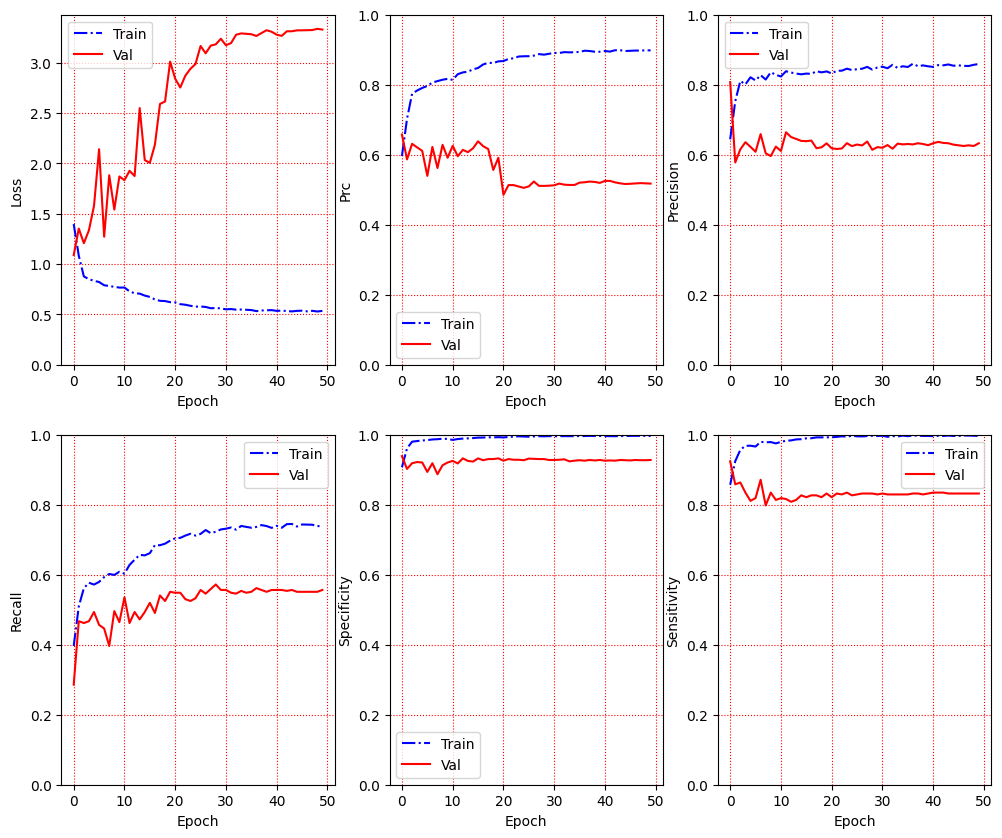

In [28]:
plot_metrics(history)

In [29]:
train_predictions_baseline = model.predict(train_iterator, batch_size=64)
test_predictions_baseline = model.predict(test_iterator, batch_size=64)
y_test = to_categorical(test_iterator.labels)


12/12 [==============================] - 195s 18s/step


In [30]:
baseline_results = model.evaluate(test_iterator,
                                  batch_size=64, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print('.......................................')

loss :  2.6035003662109375
tp :  226.0
fp :  102.0
tn :  1426.0
fn :  156.0
accuracy :  0.8649214506149292
precision :  0.6890243887901306
recall :  0.5916230082511902
auc :  0.8425979018211365
prc :  0.6034054160118103
Specificity :  0.9522251486778259
Sensitivity :  0.8795811533927917
.......................................


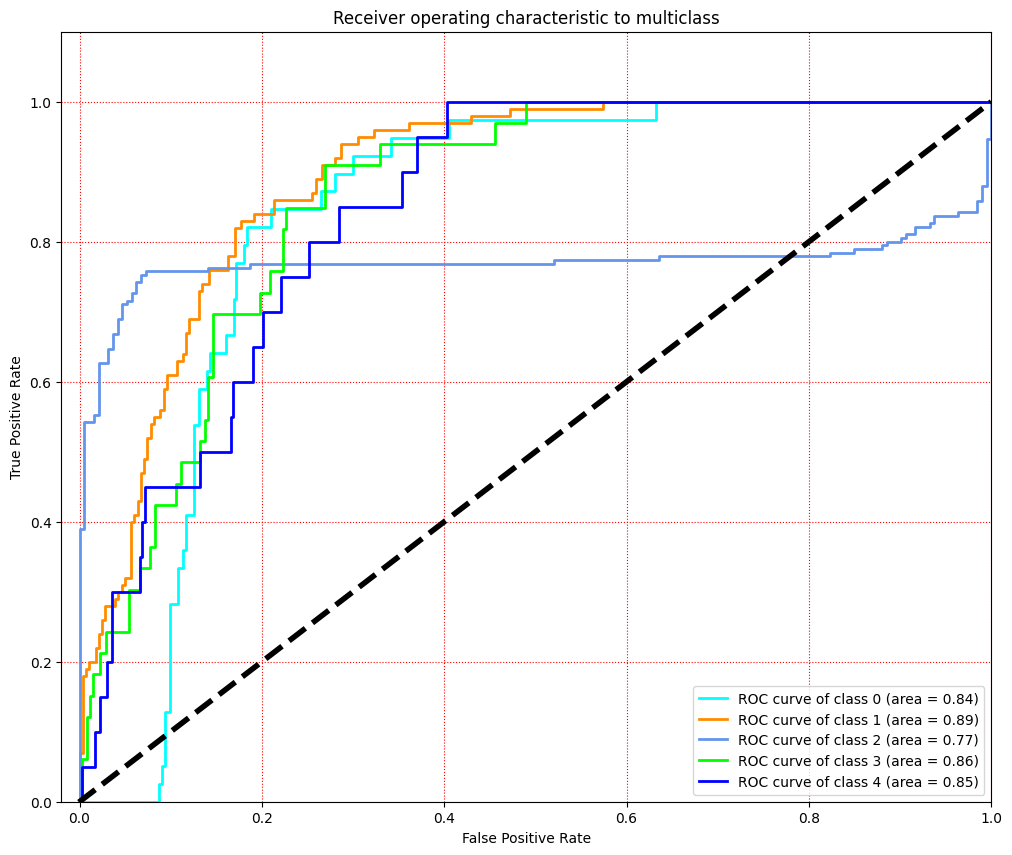

In [33]:
# Compute ROC curve and ROC area for each class

y_score = test_predictions_baseline
n_classes = 5
plot_roc(y_test, y_score, 5)

In [35]:
model.save('my_model.keras')

In [36]:
new_model = tf.keras.models.load_model('my_model.keras')

In [37]:
import pickle
with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)

In [44]:
new_model.predict(/content/drive/MyDrive/Testing After Entropy Enhancement/Test_Moderate)

SyntaxError: ignored